## UNSW_NB15 Dataset

The raw network packets of the UNSW-NB 15 dataset was created by the IXIA PerfectStorm tool in the Cyber Range Lab of the Australian Centre <br> for Cyber Security (ACCS) for generating a hybrid of real modern normal activities and synthetic contemporary attack behaviours.

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import numpy as np
import torch
import torch.nn.functional as F
from pydvl.influence import compute_influences
from pydvl.influence.torch import TorchTwiceDifferentiable

from support.common import (
    plot_losses,
)
from support.torch import (
    fit_torch_model,
    TorchLogisticRegression,TorchMLP
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim import AdamW, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from geolite2 import geolite2
from modules.lib_IF import *
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,MinMaxScaler
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)


### Load dataset

In [3]:
test = pd.read_csv('./data/UNSW_NB15_training-set.csv')
train = pd.read_csv('./data/UNSW_NB15_testing-set.csv') 
features = pd.read_csv("./data/NUSW-NB15_features.csv", encoding='cp1252')


### Description of features

In [4]:
features.head(features.shape[0])


,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


We will concat train and test dataframes in order to preprocess them together.

In [5]:
df = pd.concat([train, test])
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,52,0,0,0,1,2,2,1,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,7,1,55.880051,143.700000,4798.130981,190.980813,255,1072535109,3284291478,255,0.173208,0.100191,0.073017,903,44,0,0,1,1,2,1,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.720000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.732000,0.000000,10.954518,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  sin

The only categorical features we have are : *'proto'*, *'state'* , *'service'*

In [7]:
df.describe(include='all')


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,257673.000000,257673.000000,257673,257673,257673,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673,257673.000000
unique,NaN,NaN,133,13,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,NaN,NaN,123041,141321,117164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93000,NaN
mean,72811.823858,1.246715,NaN,NaN,NaN,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,6.582143e+05,4.889317,6.743691,912.300834,98.915462,5.419373e+03,582.251456,121.753661,1.006120e+09,1.002295e+09,119.254629,0.046038,0.023652,0.022386,137.639027,121.649703,0.102242,1.968900e+03,9.383176,1.324978,6.050467,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,NaN,0.639077
std,48929.917641,5.974305,NaN,NaN,NaN,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,2.412372e+06,65.574953,53.702222,6922.153239,1094.048691,4.903450e+04,3930.153369,127.367443,1.367795e+09,1.363877e+09,127.230477,0.092908,0.053856,0.045771,205.901118,254.041013,0.710593,4.962523e+04,10.829706,0.992300,8.173749,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,NaN,0.480269
min,1.000000,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,0.000000
25%,32210.000000,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,NaN,0.000000
50%,64419.000000,0.004285,NaN,NaN,NaN,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,1.747441e+03,0.000000,0.000000,0.381696,0.007000,6.736370e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,NaN,1.000000
75%,110923.000000,0.685777,NaN,NaN,NaN,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,2.210538e+04,3.000000,2.000000,58.094727,56.438859,2.787367e+03,119.712937,255.000000,2.007375e+09,1.992752e+09,255.000000,

Checking for missing values

In [8]:
print(df.isna().sum())


id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

Balance between target labels

<Axes: >

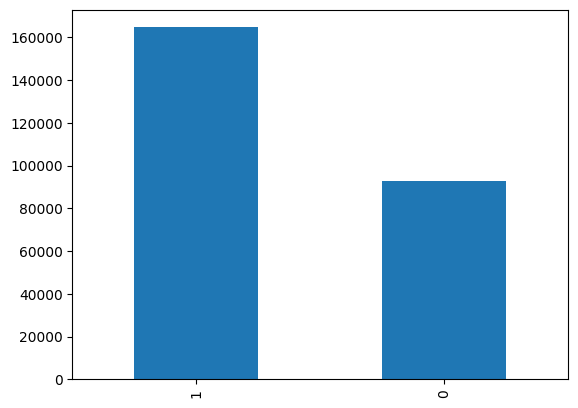

In [9]:
df['label'].value_counts().plot.bar()

In [10]:
df['label'].value_counts(normalize=True)


1    0.639077
0    0.360923
Name: label, dtype: float64

### Pre-processing and Feature Selection

The first features to drop are 'id', which is just a feature used for indexing and 'attack_cat', which is just an extension of the target feature.

In [11]:
df.drop(['id','attack_cat'],axis=1,inplace=True)

We will use the correlation matrix to find other features that might need to be dropped

C:\Users\NIKOLA~1\AppData\Local\Temp/ipykernel_40488/58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

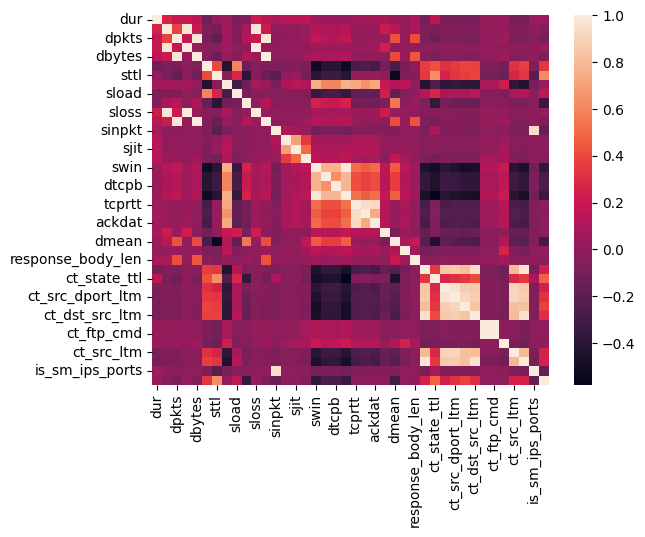

In [12]:
sns.heatmap(df.corr())

In [13]:
columns = df.select_dtypes(exclude=['object']).columns.tolist()
corr = df.corr()
correlated_vars = []
for i in range(len(columns) - 1):
    for j in range(i+1, len(columns)):
        if corr[columns[i]][columns[j]] > 0.95:
            print(columns[i], columns[j], corr[columns[i]][columns[j]])
            correlated_vars.append(columns[j])

C:\Users\NIKOLA~1\AppData\Local\Temp/ipykernel_40488/3942467889.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


spkts sbytes 0.964393217155871
spkts sloss 0.9718594116510776
dpkts dbytes 0.9734453279792796
dpkts dloss 0.979612084935938
sbytes sloss 0.9957715772406667
dbytes dloss 0.996711133831455
swin dwin 0.9804584289136496
ct_srv_src ct_dst_src_ltm 0.9539519771685965
ct_srv_src ct_srv_dst 0.9794668130725528
ct_dst_ltm ct_src_dport_ltm 0.9615176986568883
ct_dst_src_ltm ct_srv_dst 0.9603212131064117
is_ftp_login ct_ftp_cmd 0.9988554882935726


In [14]:
df = df.drop(columns=correlated_vars)

#### Categorical Features

In [15]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state
count,257673,257673,257673
unique,133,13,11
top,tcp,-,FIN
freq,123041,141321,117164


Some features have very high cardinalities, and this section reduces the cardinality to 5 or 6 per feature. <br> The logic is to take the top 5 occuring labels in the feature as the labels and set the remainder to '-' (seldom used) labels.

In [16]:
for feature in df_cat.columns:
    if df_cat[feature].nunique()>6:
        df[feature] = np.where(df[feature].isin(df[feature].value_counts().head().index), df[feature], '-')

In [17]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state
count,257673,257673,257673
unique,6,5,6
top,tcp,-,FIN
freq,123041,149701,117164


In [18]:
df.head()

,dur,proto,service,state,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,label
0,0.121478,tcp,-,FIN,6,4,74.087490,252,254,14158.942380,8495.365234,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,0,0,1,0,0
1,0.649902,tcp,-,FIN,14,38,78.473372,62,252,8395.112305,503571.312500,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,0,0,1,0,0
2,1.623129,tcp,-,FIN,8,16,14.170161,62,252,1572.271851,60929.230470,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,0,0,2,0,0
3,1.681642,tcp,-,FIN,12,12,13.677108,62,252,2740.178955,3358.622070,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,0,2,0,0
4,0.449454,tcp,-,FIN,10,6,33.373826,254,252,8561.499023,3987.059814,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,1,0,0,2,0,0


### Train test split dataset

In [19]:
X = df.drop(columns='label')
y = df['label']

In [20]:
train, test, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=42,stratify=y)

In [21]:
train_labels.value_counts(normalize=True)

1    0.639077
0    0.360923
Name: label, dtype: float64

In [22]:
test_labels.value_counts(normalize=True)

1    0.639078
0    0.360922
Name: label, dtype: float64

In [23]:
#train = train.astype(np.float32)
train_labels = train_labels.astype(np.float32)
#test = test.astype(np.float32)
test_labels = test_labels.astype(np.float32)

In [24]:
cat_columns = X.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_columns = X.select_dtypes(exclude=['object']).columns.tolist()

### Model creation and Training

#### Retrain a PyTorch Neural Network with the best parameters
We retrain the neural network to use it for computing influences.

In [25]:
trainn, val, trainn_labels, val_labels = train_test_split(train,train_labels, test_size=0.2, random_state=42,stratify=train_labels)

In [26]:
def preprocess_data(data,one_hot_encoded_features,numerical_features):

    #one hot encoding of choosen features
    new_data = pd.concat([data, pd.get_dummies(data[one_hot_encoded_features])], axis=1)
    new_data = new_data.drop(columns=one_hot_encoded_features)

    scaler = StandardScaler()
    new_data[numerical_features] = scaler.fit_transform(new_data[numerical_features])
    
    return new_data

In [27]:
new_train = preprocess_data(trainn,cat_columns,numeric_columns)
new_val = preprocess_data(val,cat_columns,numeric_columns)
new_test = preprocess_data(test,cat_columns,numeric_columns)

In [28]:
training_data_loader = DataLoader(
    TensorDataset(
        torch.as_tensor(new_train.values,dtype=torch.float),
        torch.as_tensor(trainn_labels.to_numpy(), dtype=torch.float).unsqueeze(-1),
    ),
    batch_size=32,
    shuffle=True,
)

val_data_loader = DataLoader(
    TensorDataset(
        torch.as_tensor(new_val.values,dtype=torch.float),
        torch.as_tensor(val_labels.to_numpy(), dtype=torch.float).unsqueeze(-1),
    ),
    batch_size=32,
    shuffle=True,
)

In [29]:
from sklearn.utils.class_weight import compute_class_weight
import torch.optim as optim
import torch.nn as nn

num_epochs = 10
lr = 0.0001
weight_decay = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


feature_dimension = 47
num_classes = 1
network_size = [32,32,32]
layers_size = [feature_dimension, *network_size, num_classes]

nn_model = TorchMLP(layers_size)
nn_model.to(device)

optimizer = torch.optim.AdamW(params=nn_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = nn.BCELoss()

losses = fit_torch_model(
    model=nn_model,
    training_data=training_data_loader,
    val_data=val_data_loader,
    loss=F.binary_cross_entropy,
    optimizer=optimizer,
    class_weights=None,
    scheduler=scheduler,
    num_epochs=num_epochs,
)

Model fitting:   0%|          | 0/10 [00:00<?, ?it/s]

Model fitting: 100%|██████████| 10/10 [03:28<00:00, 20.83s/it]


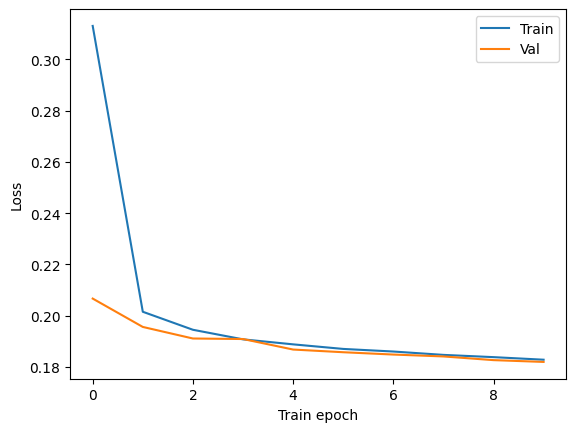

In [30]:
plot_losses(losses)

Accuracy Score is 0.9016325580191974


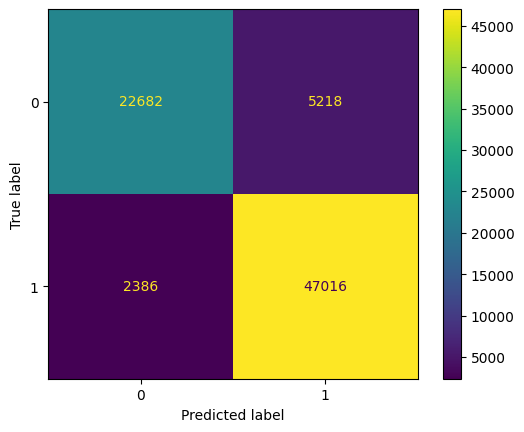

In [31]:
from sklearn.metrics import accuracy_score
nn_model.eval()
pred_probabilities = nn_model(torch.tensor(new_test.values, dtype=torch.float)).detach()

pred_y_test = [1 if prob > 0.5 else 0 for prob in pred_probabilities]
print(f'Accuracy Score is {accuracy_score(test_labels,pred_y_test)}')
cm = confusion_matrix(torch.tensor(test_labels.to_numpy(), dtype=torch.float64), pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

## Create gRPC Client

In [32]:
new_train.reset_index(drop=True,inplace=True)
trainn.reset_index(drop=True,inplace=True)
new_test.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

trainn_labels.reset_index(drop=True,inplace=True)
test_labels.reset_index(drop=True,inplace=True)

In [33]:
import grpc
import influence_service_pb2
import influence_service_pb2_grpc
import io


def generate_dataframe_chunks(train_data,model, test_data, train_labels,test_labels,num_influential, untransformed_train, untransformed_train_labels, chunk_size=1000):
    for i in range(0, len(train_data), chunk_size):
        chunk = train_data[i:i + chunk_size]
        chunk_train = train_labels[i:i + chunk_size]
        chunk_data = chunk.to_parquet(None)
        chunk_train = chunk_train.to_parquet(None)  
        
        yield influence_service_pb2.InfluenceRequest(
                train_data=chunk_data,
                model=model.getvalue(),
                test_data=test_data.to_parquet(None),
                train_labels = chunk_train,
                test_labels = test_labels.to_frame().to_parquet(None),
                num_influential = num_influential,
                untransformed_train = untransformed_train.to_parquet(None),
                untransformed_train_labels = untransformed_train_labels.to_frame().to_parquet(None)
            )


def compute_influences_via_grpc(train_data,model, test_data, train_labels,test_labels,num_influential, untransformed_train, untransformed_train_labels):
    channel = grpc.insecure_channel('localhost:50051')
    stub = influence_service_pb2_grpc.InfluenceServiceStub(channel)

    # Serialize the PyTorch model and data
    model_bytes = io.BytesIO()
    torch.save(model, model_bytes)

    # Create a sample DataFrame for demonstrdataframe = pd.DataFrame(sample_data)
    try:
        response = stub.ComputeInfluences(generate_dataframe_chunks(train_data,model_bytes, test_data, train_labels,test_labels,num_influential, untransformed_train, untransformed_train_labels))
        return response.influences, response.positive, response.negative
    except grpc.RpcError as e:
        print(f"Error calling StreamDataFrame: {e}")

In [34]:
# Compute influences via gRPC
influences,positive,negative = compute_influences_via_grpc(new_train.loc[:4999],nn_model, new_test.iloc[[6,7,12,75,65,77193]], trainn_labels.to_frame().loc[:4999], test_labels.loc[[6,7,12,75,65,77193]],5, trainn.loc[0:4999], trainn_labels.loc[0:4999])
inf = pd.DataFrame(np.array(influences).reshape(6,5000),columns=[str(i) for i in range(0, 5000)])
positive =  pd.read_parquet(io.BytesIO(positive))
negative =  pd.read_parquet(io.BytesIO(negative))

#print("Influences:", inf)

In [35]:
positive

,dur,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,proto_-,proto_arp,proto_ospf,proto_tcp,proto_udp,proto_unas,service_-,service_dns,service_ftp-data,service_http,service_smtp,state_-,state_CON,state_FIN,state_INT,state_REQ,state_RST,label,influence
4216,-0.135911,-0.072991,-0.088460,-0.569358,-1.149438,1.482448,-0.379188,-0.264299,-0.126080,-0.038836,-0.059939,-0.126176,1.044697,-0.143111,1.120497,0.684464,0.401672,0.912519,-0.261430,0.160229,1.097594,-0.034870,-0.496267,-0.327243,-0.372852,-0.176489,-0.111259,12.850204,-0.452132,-0.121877,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0.0,88.825562
329,8.008013,-0.000814,-0.006859,-0.569595,-1.149438,1.482448,-0.379260,-0.272776,0.237445,2.519088,6.965766,2.614835,1.044697,1.069837,-0.264669,0.737555,0.721975,0.645993,-0.256587,0.069487,1.097594,-0.037028,-0.588854,-0.327243,-0.372852,-0.176489,-0.111259,8.503231,1.703106,-0.121877,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0.0,87.503998
3701,-0.030153,-0.072991,-0.072140,-0.569489,-1.149438,1.482448,-0.379233,-0.269274,-0.116014,0.010260,0.070290,-0.096420,1.044697,0.344647,1.137503,0.884094,0.533069,1.162043,-0.280802,0.037924,1.097594,-0.035609,-0.311093,-0.327243,-0.372852,-0.176489,-0.111259,12.850204,-0.452132,-0.121877,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0.0,70.981529
495,-0.033677,0.287894,-0.039500,-0.569166,0.722962,1.482448,-0.376528,-0.271131,-0.130538,-0.018634,-0.063678,-0.105938,1.044697,1.316798,1.963274,0.162075,0.147829,0.154579,4.838119,-0.305318,1.097594,-0.039685,-0.681442,-0.327243,-0.618620,-0.519571,-0.111259,1.258277,-0.691603,-0.121877,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0,59.859272
2310,-0.044803,0.287894,-0.039500,-0.569137,0.722962,1.482448,-0.376342,-0.271009,-0.130708,-0.024253,-0.078047,-0.121801,1.044697,0.478961,-0.440919,0.565704,0.416360,0.655755,4.838119,-0.305318,1.097594,-0.039685,-0.774029,-0.327243,-0.618620,-0.519571,-0.111259,1.258277,-0.691603,-0.121877,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0,57.695881


In [36]:
negative

,dur,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,proto_-,proto_arp,proto_ospf,proto_tcp,proto_udp,proto_unas,service_-,service_dns,service_ftp-data,service_http,service_smtp,state_-,state_CON,state_FIN,state_INT,state_REQ,state_RST,label,influence
34,-0.087899,-0.072991,-0.072140,-0.569436,-1.149438,1.482448,-0.379219,-0.267111,-0.121510,-0.021771,-0.010881,-0.115606,1.044697,0.674913,0.557038,0.554604,0.505707,0.529128,-0.275959,0.077377,1.097594,-0.036868,-0.125918,-0.327243,-0.372852,-0.176489,-0.111259,12.850204,-0.452132,-0.121877,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1.0,-79.491539
2583,-0.120180,-0.072991,-0.088460,-0.569401,-1.149438,1.482448,-0.379199,-0.265540,-0.124583,-0.033439,-0.047685,-0.121491,1.044697,-0.373300,0.414084,0.842278,0.934350,0.609553,-0.251744,0.187846,1.097594,-0.035050,-0.681442,-0.327243,-0.495736,-0.519571,-0.111259,5.605250,-0.691603,-0.121877,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1.0,-71.298653
73,0.039038,-0.072991,-0.088460,-0.569528,-1.149438,1.482448,-0.379240,-0.270663,-0.109428,0.092999,0.089590,-0.045246,1.044697,0.235578,1.172426,1.184609,0.896024,1.345006,-0.266273,0.093158,1.097594,-0.036528,-0.681442,-0.327243,-0.495736,-0.348030,-0.111259,5.605250,-0.571867,-0.121877,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1.0,-70.162743
4021,-0.071506,-0.072991,-0.088460,-0.569471,-1.149438,1.482448,-0.379225,-0.268384,-0.119950,0.001249,-0.013653,-0.101229,1.044697,1.002946,-0.595759,1.353338,1.344376,1.162438,-0.285645,0.156283,1.097594,-0.034870,-0.588854,-0.327243,-0.495736,-0.348030,-0.111259,5.605250,-0.571867,-0.121877,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1.0,-69.248886
2414,0.366526,1.659257,0.188982,-0.569074,-1.149438,1.482448,-0.375174,-0.271223,-0.131077,-0.015732,-0.077341,-0.115107,1.044697,1.754111,-0.111711,1.476252,1.481396,1.250607,5.734051,-0.309263,1.097594,-0.039685,-0.774029,-0.327243,-0.618620,-0.519571,-0.111259,1.258277,-0.691603,-0.121877,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,-61.966980
